In [18]:
# Usar o DR4
# Retirar os dados com flag > 3
# Retirar os dados que possivelmente são estrelas (classificação < 0.3)
# Subtrair a extinção
# Fazer um cross-matching com a tabela do Erik

from astropy.io import fits
import bagpipes as pipes
import numpy as np
import pandas as pd
import matplotlib as plt
import numpy as np

In [7]:
import pandas as pd
from astroML.crossmatch import crossmatch_angular
import sqlite3

df1 = pd.read_csv('SpecZ_Catalogue_20240124.csv')

df2 = pd.read_csv('tableSPlus_corrected.txt', sep=",", header=0)
df2.columns = df2.columns.str.strip()

cols1 = df1.columns.tolist()

cols1 = cols1[:2]
df1_Coords = df1[cols1]

cols2 = df2.columns.tolist()

cols2 = cols2[3:5]
df2_Coords = df2[cols2]

print(df1_Coords.values)

C:\Users\redbr\AppData\Local\Temp\ipykernel_45028\164661356.py:5: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('SpecZ_Catalogue_20240124.csv')


[[ 2.70803750e+02 -3.02083333e+00]
 [ 1.95157852e+02 -3.50173996e+00]
 [ 2.11814490e+02 -2.02529560e+00]
 ...
 [ 1.76929890e+02 -7.63200000e-02]
 [ 1.76962440e+02 -5.75400000e-02]
 [ 1.77014230e+02 -6.93600000e-02]]


In [6]:
# crossmatch catalogs
max_radius = 1. / 3600  # 1 arcsec
# note, that for the below to work the first 2 columns of the catalogs should be ra, dec
# also, df_1 should be the longer of the 2 catalogs, else there will be index errors
dist, ind = crossmatch_angular(df1_Coords.values, df2_Coords.values, max_radius)
match = ~np.isinf(dist)
# THE DESIRED SOLUTION IS THEN:
df_crossed = df1[match]


conn = sqlite3.connect(':memory:')
#write the tables
df_crossed.to_sql('catSpec', conn, index=False)
df2.to_sql('catSPLUS', conn, index=False)

qry = '''
    select *
    from catSpec
    inner join catSPLUS on
        (catSpec.RA BETWEEN catSPLUS.RA - 0.00027 and catSPLUS.RA + 0.00027)
        and (catSpec.DEC BETWEEN catSPLUS.DEC - 0.00027 and catSPLUS.DEC + 0.00027)
    where class_spec = 'GALAXY'
    '''
df_crossed = pd.read_sql_query(qry, conn)

print(df_crossed)


# Save cross matched dataframe
df_crossed.to_csv('crossmatchData.txt', index=False)

             RA        DEC         z       e_z         f_z class_spec  \
0    150.608750 -24.554500  0.064228  0.000150  KEEP(SLS )     GALAXY   
1    151.386417 -24.288000  0.153500  0.000050     KEEP(4)     GALAXY   
2    149.985500 -24.266444  0.045888  0.000083  KEEP(SLS )     GALAXY   
3    151.434833 -23.883278  0.053057  0.000150  KEEP(SLS )     GALAXY   
4    152.508917 -24.328472  0.031905  0.000043  KEEP(    )     GALAXY   
..          ...        ...       ...       ...         ...        ...   
209  156.499850 -25.184065  0.686349  0.000063        None     GALAXY   
210  155.243500 -24.929083  0.126201  0.000150  KEEP(SLS )     GALAXY   
211  156.591750 -24.930529  0.683624  0.000006        None     GALAXY   
212  156.610100 -24.907412  0.539532  0.000039        None     GALAXY   
213  156.406583 -24.854889  0.032562  0.000103  KEEP(SLS )     GALAXY   

    original_class_spec                            source  \
0                     G  EXTERNAL_NED_20096dF...C...0000J   
1

In [2]:
import numpy as np

def ab_magnitude_to_flux(m_ab):
    """
    Convert magnitude from the AB system to flux in microjansky (µJy).

    Parameters:
    m_ab (float): Magnitude in the AB system.

    Returns:
    float: Flux in microjansky (µJy).
    """
    flux_uJy = 10**((m_ab - 8.6)/-2.5) * 10**6
    return flux_uJy.astype(float)

def mag_to_flux_error(sigma_m, flux):
    return (sigma_m * flux/1.086).astype(float)

This objects' information is 
ID: DR4_3_HYDRA-0012_0019006
RA: 152.17591666667
DEC: -24.24608333333
Redshift: 0.031569


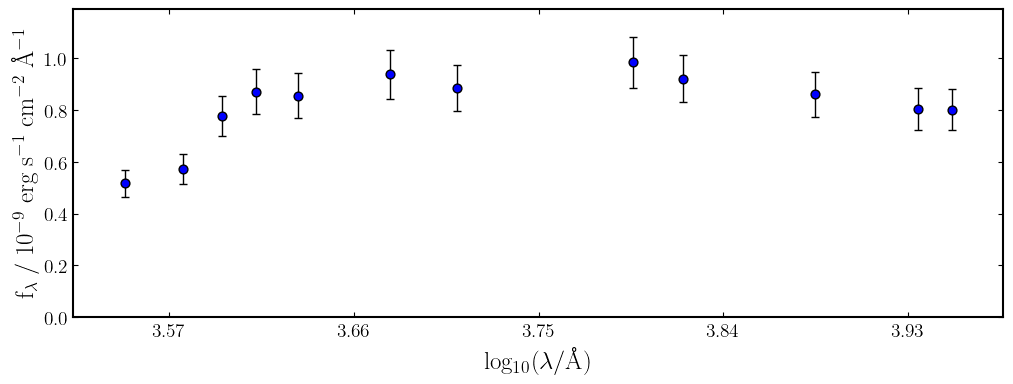

MultiNest not available. Switching to nautilus.

Bagpipes: fitting object 6


Completed in 204.5 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.548      0.972      1.390
exponential:age                2.607      5.711      9.985
exponential:massformed        14.055     14.598     14.897
exponential:metallicity        0.347      0.969      1.785
exponential:tau                3.239      5.851      8.551
redshift                       0.003      0.006      0.008




In [3]:
import bagpipes as pipes
import numpy as np

def load_Splus(ID):
    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("crossmatchData.txt",
                     usecols=(13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                              25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36), delimiter=',', skiprows=1)

    # Find the correct row for the object we want.
    row = int(ID) - 1

    #Get our objects' ID
    objectInfoList = np.loadtxt("crossmatchData.txt", dtype=str, usecols=(0, 1, 2, 8), delimiter=',', skiprows=1)
    print(f'This objects\' information is \nID: {objectInfoList[row, 3]}\nRA: {objectInfoList[row, 0]}\nDEC: {objectInfoList[row, 1]}\nRedshift: {objectInfoList[row, 2]}')

    # Extract the object we want from the catalogue.
    fluxes = ab_magnitude_to_flux(cat[row, :12])
    fluxerrs = mag_to_flux_error(cat[row, 12:], fluxes)

    # Turn these into a 2D array.
    photometry = np.c_[fluxes * 10**6, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            

    for i in range(len(photometry)):
        max_snr = 10.

        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry


splusFilters = np.loadtxt("filtersList.txt", dtype="str")

galaxy = pipes.galaxy("6", load_Splus, spectrum_exists=False, filt_list=splusFilters)
fig = galaxy.plot()

exp = {}
exp["age"] = (0.1, 15.)

exp["tau"] = (0., 10.)
exp["massformed"] = (0., 15.)
exp["metallicity"] = (0., 2.5)

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)

fit_instructions = {}
fit_instructions["redshift"] = (0., 1)
fit_instructions["exponential"] = exp
fit_instructions["dust"] = dust

fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)

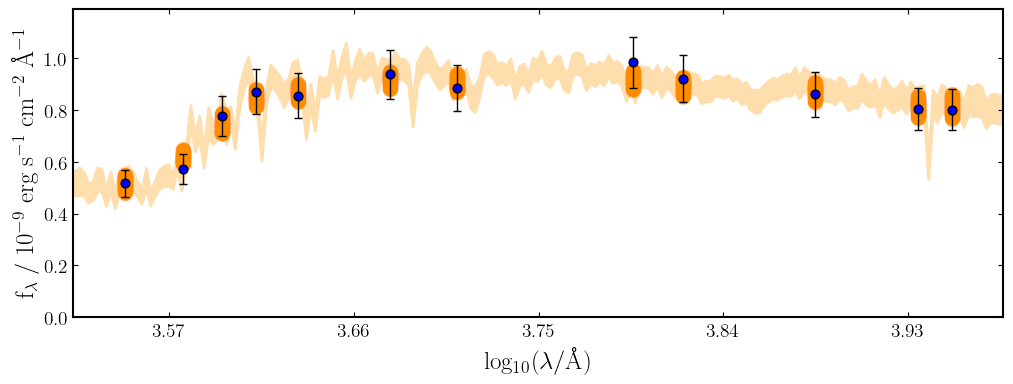

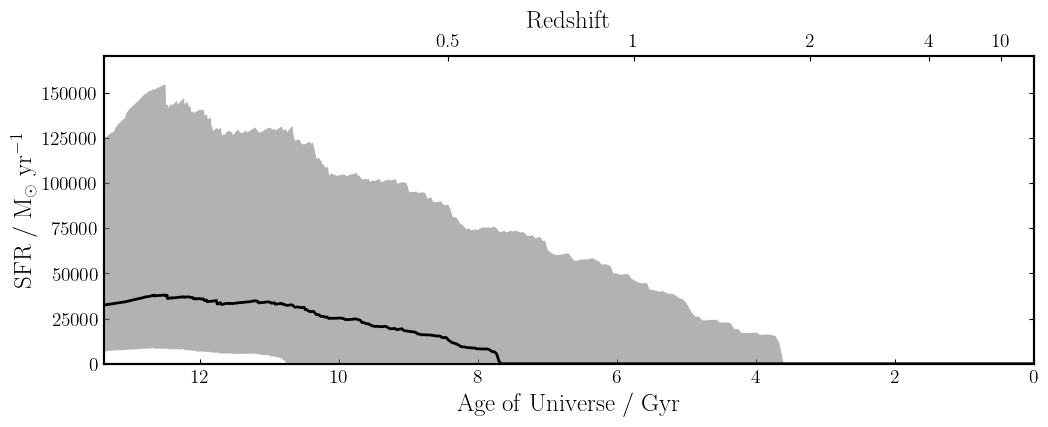

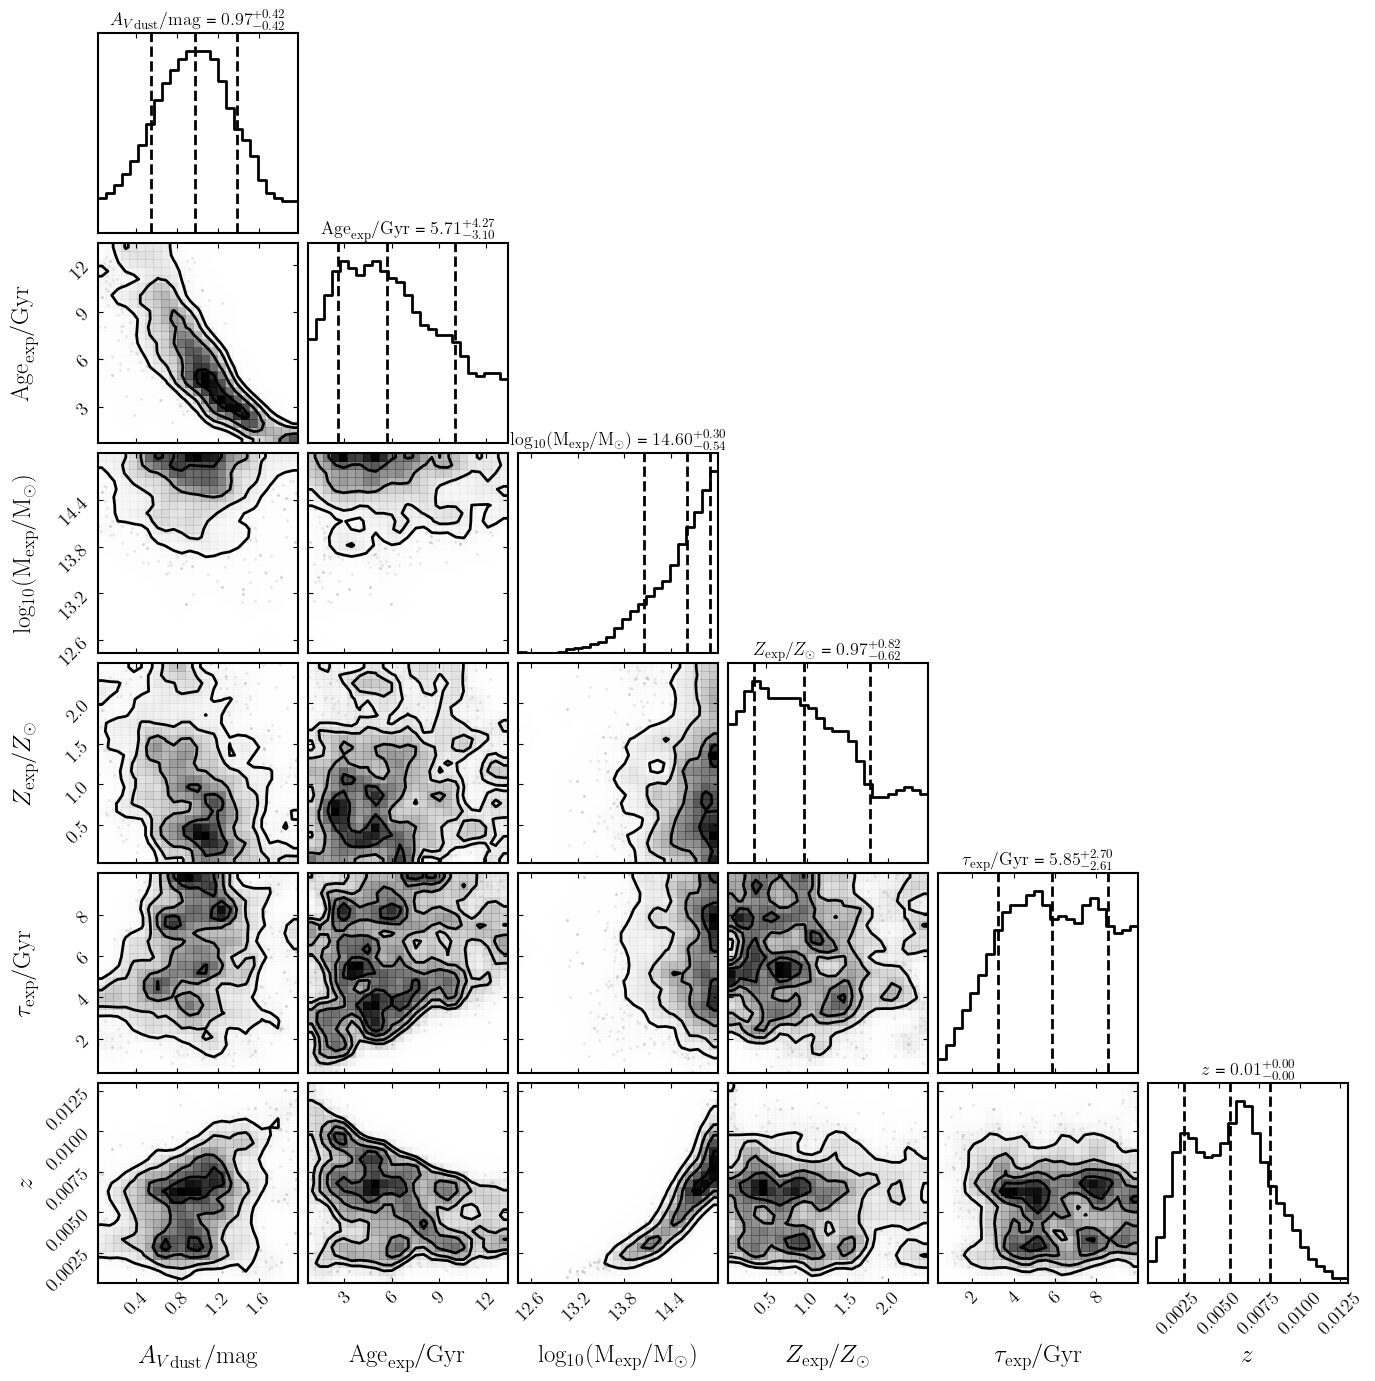

In [4]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

In [7]:
import h5py
 
#Open the H5 file in read mode
with h5py.File('pipes/posterior/./39.h5', 'r') as file:
    print("Keys: %s" % file.keys())
    a_group_key = list(file.keys())[0]
     
    # Getting the data
    data = list(file[a_group_key])
    print(data)

Keys: <KeysViewHDF5 ['conf_int', 'lnlike', 'lnz', 'lnz_err', 'median', 'samples2d']>
[array([2.54284299e+00, 1.44589007e+01, 2.77463882e+02, 1.01513779e+01,
       2.55875237e-01, 3.50821380e+00, 8.46125405e-02, 1.38582553e+00]), array([1.22034798e+01, 2.56455092e+02, 8.36437160e+02, 1.07775995e+01,
       1.83889171e+00, 4.43028078e+00, 4.34266082e-01, 1.76991325e+00])]


This objects' information is 
ID: DR4_3_MC0073_0011777
RA: 18.719395677094237
DEC: -71.54998447174049


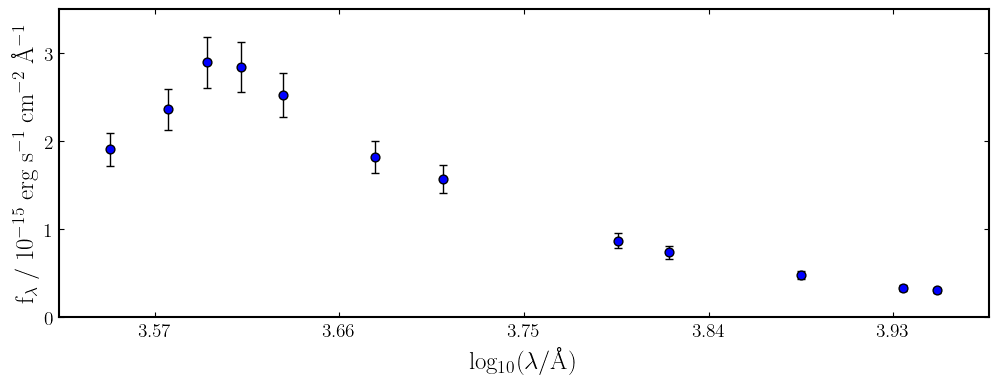

MultiNest not available. Switching to nautilus.

Bagpipes: fitting object 8


Completed in 115.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
exponential:age                0.107      0.148      0.195
exponential:massformed         6.676      7.236      7.556
exponential:metallicity        0.015      0.047      0.112
exponential:tau                1.868      5.199      8.421
redshift                       0.003      0.006      0.009




In [7]:
import bagpipes as pipes
import numpy as np

def load_Splus(ID):
    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("NGC_458_corrected.txt",
                     usecols=(5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
                              17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28), delimiter=',', skiprows=1)

    # Find the correct row for the object we want.
    row = int(ID) - 1

    #Get our objects' ID
    objectInfoList = np.loadtxt("NGC_458_corrected.txt", dtype=str, usecols=(0, 3, 4), delimiter=',', skiprows=1)
    print(f'This objects\' information is \nID: {objectInfoList[0]}\nRA: {objectInfoList[1]}\nDEC: {objectInfoList[2]}')

    # Extract the object we want from the catalogue.
    fluxes = ab_magnitude_to_flux(cat[:12])
    fluxerrs = mag_to_flux_error(cat[12:], fluxes)

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            

    for i in range(len(photometry)):
        max_snr = 10.

        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry


splusFilters = np.loadtxt("filtersList.txt", dtype="str")

galaxy = pipes.galaxy("8", load_Splus, spectrum_exists=False, filt_list=splusFilters)
fig = galaxy.plot()

exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0., 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 13.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 1)            # vary Z between 0 and 2.5 Z_oldsolar

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = 0
dust["eta"] = 0

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["redshift"] = (0., 0.01)  # Vary observed redshift from 0 to 10
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust

fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)

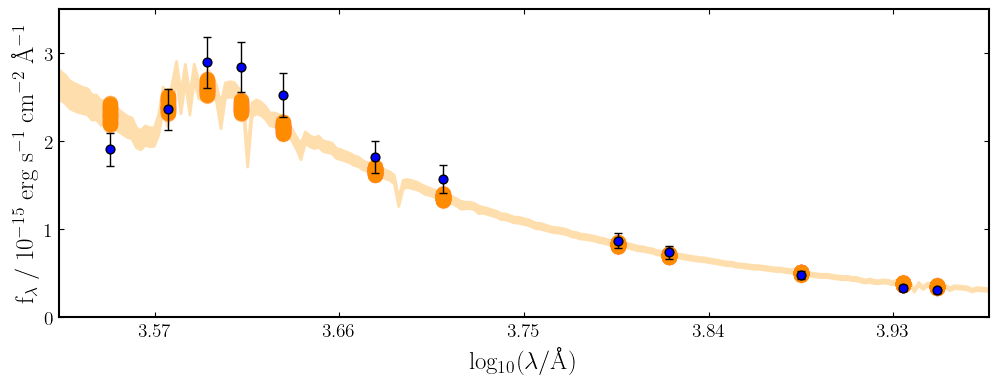

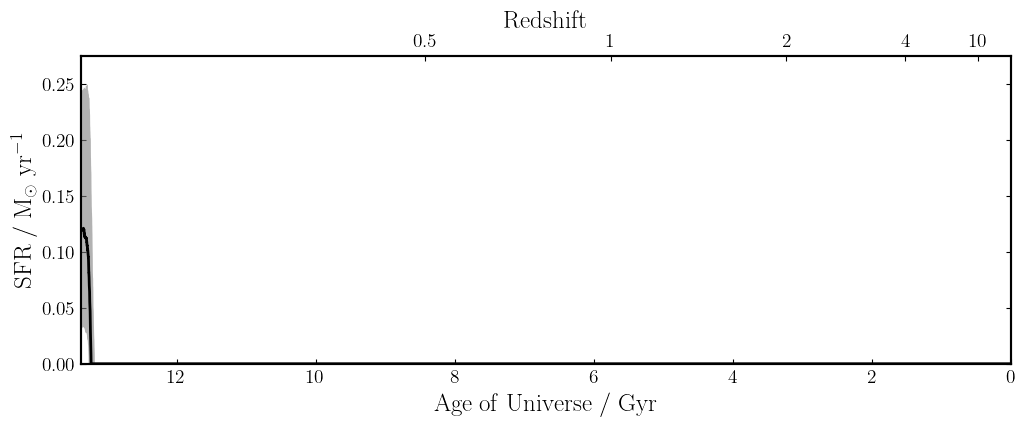

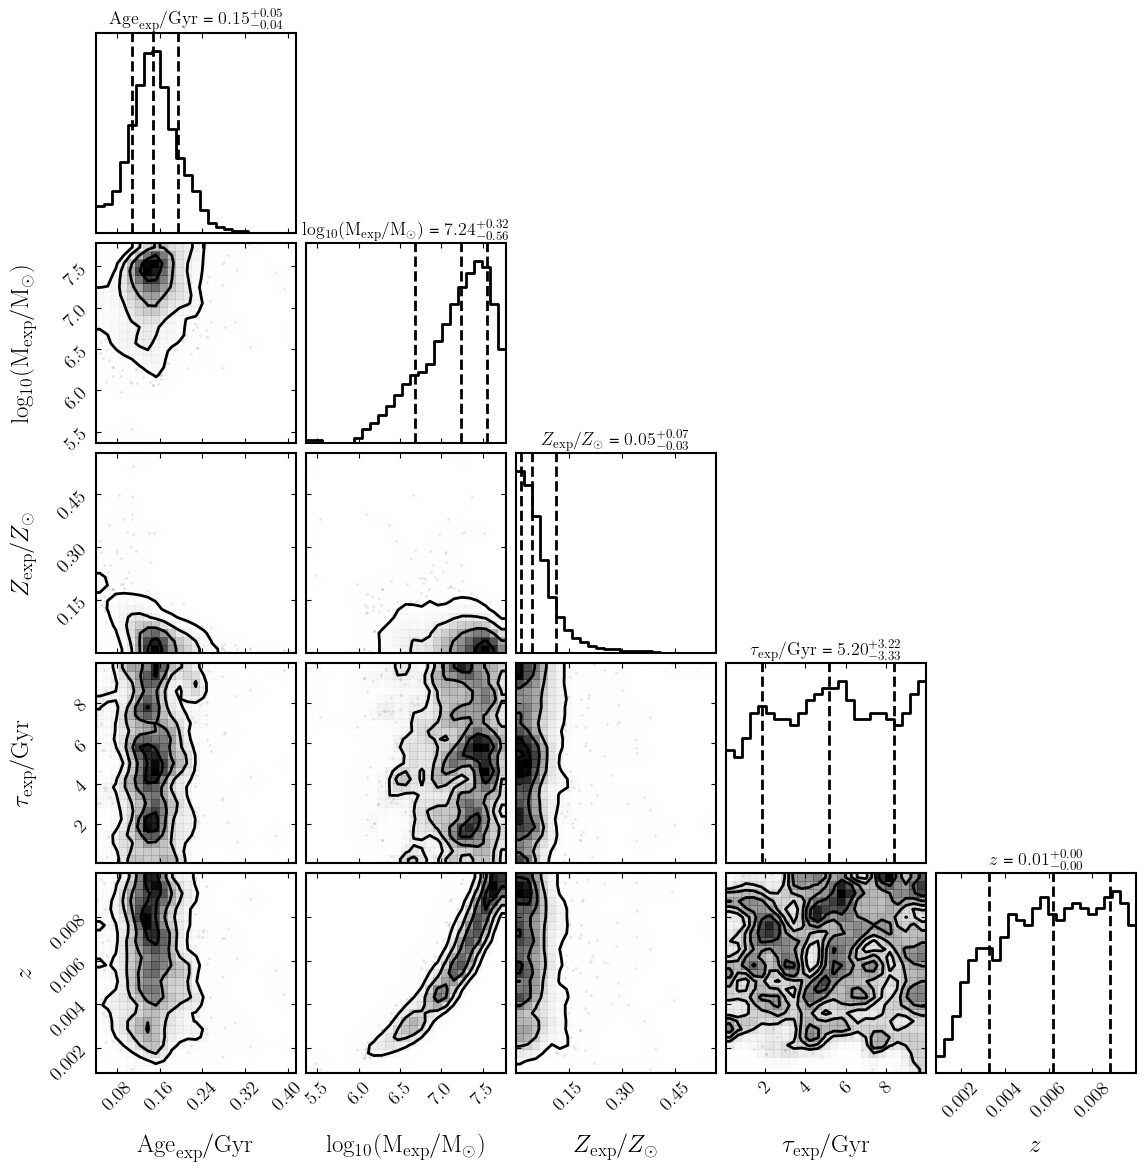

In [8]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)